In [1]:
import numpy as np
from scipy.linalg import lu_factor, lu_solve

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(color_codes=True)

from tqdm import tqdm

In [2]:
from synthetic_datasets import *
from loss_models import *
from plot import *

# Newton approximation

Based on the assumption that logistic regression is "similar" to linear regression in that taking one Newton step after reweighting gets pretty close to the result of retraining, we can ask how well the Newton approximation does.

## Change in parameters

1. Actual: $\Delta \hat{\theta}_w^*(s) = \hat{\theta}(s+w) - \hat{\theta}(s)$
2. First-order: $\Delta \hat{\theta}_w(s) = -H(s, \hat{\theta}(s))^{-1} g(w, \hat{\theta}(s))$
3. Newton: $\Delta \hat{\theta}_w^{newton}(s) = -H(s + w, \hat{\theta}(s))^{-1} g(w, \hat{\theta}(s))$

## Change in loss

1. Actual:
$\Delta \ell(z_{test})_w^* = \ell(z_{test}, \hat{\theta}(s+w)) - \ell(z_{test}, \hat{\theta}(s))$
2. First-order:
$\Delta \ell(z_{test})_w =
\nabla_\theta \ell(z_{test}, \hat{\theta}(s))^\top
\Delta \hat{\theta}_w(s)
=
-\nabla_\theta \ell(z_{test}, \hat{\theta}(s))^\top
H(s, \hat{\theta}(s))^{-1} g(w, \hat{\theta}(s))$
3. Newton:
$\Delta \ell(z_{test})_w^{newton}(s) =
\nabla_\theta \ell(z_{test}, \hat{\theta}(s))^\top
\Delta \hat{\theta}_w^{newton}(s)
=
-\nabla_\theta \ell(z_{test}, \hat{\theta}(s))^\top
H(s + w, \hat{\theta}(s))^{-1} g(w, \hat{\theta}(s))$

## Experiment

For random data points and random subsets, we will compute the actual change in loss and both approximations to the change in loss (self-influence) and produce scatter plots of all three pairs.

In [3]:
def compare_approximations(X, y, lm=LogisticRegression(), num_samples=1000, K=1, reg=0):    
    N, D = X.shape
    
    s = np.ones(N)
    theta_s = lm.theta(X, y, s)
    H_s_s = lm.H(X, y, s, theta_s)
    invH_s_s = lu_factor(H_s_s)
    
    I = []
    for i in tqdm(range(num_samples)):
        indices = np.random.choice(np.arange(N), K, replace=False)
        w = np.zeros(N)
        w[indices] = 1
        
        theta_sw = lm.theta(X, y, s + w)
        H_sw_s = lm.H(X, y, s + w, theta_s)
        invH_sw_s = lu_factor(H_sw_s)
        g_s = lm.g(X, y, w, theta_s)
        
        dtheta_p = -lu_solve(invH_s_s, g_s)
        dtheta_n = -lu_solve(invH_sw_s, g_s)
        
        dl_a = lm.L(X, y, w, theta_sw) - lm.L(X, y, w, theta_s)
        dl_p = np.dot(g_s, dtheta_p)
        dl_n = np.dot(g_s, dtheta_n)
        
        I.append((dl_a, dl_p, dl_n))
    
    I = np.array(I)
    I_types = ["Actual", "First-order", "Newton"]
        
    fig, axs = plt.subplots(3, 1, figsize=(8, 24), squeeze=False)
    
    for ax_row, compare_pair in zip(axs, [(0, 1), (0, 2), (1, 2)]):
        I_x = I[:, compare_pair[0]]
        I_y = I[:, compare_pair[1]]
        type_x = I_types[compare_pair[0]]
        type_y = I_types[compare_pair[1]]
        
        plot_correlation(ax_row[0], I_x, I_y,
                         xlabel="{} influence".format(type_x),
                         ylabel="{} influence".format(type_y),
                         title="{} against {}".format(type_y, type_x),
                         balanced=False)

In [4]:
N, D = 1000, 3
X, y = generate_gaussian_mixture(N, D, separation=2, seed=0)

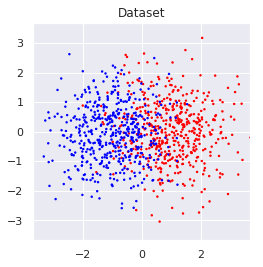

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_dataset(ax, X, y)

100%|██████████| 1000/1000 [00:01<00:00, 618.48it/s]


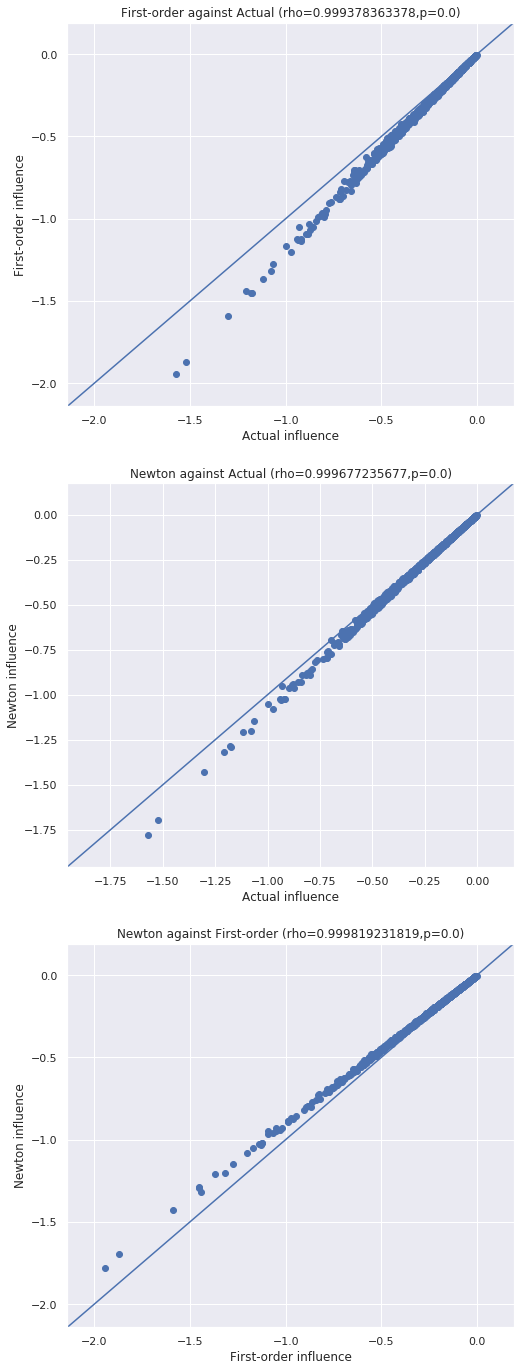

In [6]:
compare_approximations(X, y, num_samples=1000, K=100)

# With increasing weight

In [7]:
def compare_approximations_t(X_orig, y_orig, z_sub, lm=LogisticRegression(), t_samples=100):    
    N, D = X_orig.shape
    X = np.vstack([X_orig, z_sub[0]])
    y = np.hstack([y_orig, z_sub[1]])
    
    s, w = np.ones(N + 1), np.zeros(N + 1)
    w[-1] = -1
    
    theta_s = lm.theta(X, y, s)
    H_s_s = lm.H(X, y, s, theta_s)
    invH_s_s = lu_factor(H_s_s)
    
    T = np.linspace(0, 1, t_samples)
    theta_sTw = [lm.theta(X, y, s + t * w) for t in T]
    H_sTw_s = [lm.H(X, y, s + t * w, theta_s) for t in T]
    g_Tw_s = [lm.g(X, y, t * w, theta_s) for t in T]
    
    dtheta_p_T = [-lu_solve(invH_s_s, g_tw_s) for g_tw_s in g_Tw_s]
    dtheta_n_T = [-lu_solve(lu_factor(H_stw_s), g_tw_s) for g_tw_s, H_stw_s in zip(g_Tw_s, H_sTw_s)]
    
    #dl_a_T = (np.array([lm.L(z_sub[0], z_sub[1], 1, theta_stw) for theta_stw in theta_sTw]) -
    #          lm.L(z_sub[0], z_sub[1], 1, theta_s))
    dl_a_T = np.array([-np.dot(g_tw_s, theta_stw - theta_s) for g_tw_s, theta_stw in zip(g_Tw_s, theta_sTw)])
    dl_p_T = np.array([-np.dot(g_tw_s, dtheta_p_t) for g_tw_s, dtheta_p_t in zip(g_Tw_s, dtheta_p_T)])
    dl_n_T = np.array([-np.dot(g_tw_s, dtheta_n_t) for g_tw_s, dtheta_n_t in zip(g_Tw_s, dtheta_n_T)])
    
    I = np.vstack([dl_a_T, dl_p_T, dl_n_T]).T
    I_types = ["'First-order' actual", "First-order", "Newton"]
        
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), squeeze=False)
    
    annotations = [(z_sub[0], z_sub[1], '$z_{new}$')]
    plot_dataset(axs[0][0], X_orig, y_orig, annotations)
    plot_decision_boundary(axs[0][0], theta_s)
    plot_hessian(axs[0][0], H_s_s)
    
    for i, I_type in enumerate(I_types):
        plot_lines(axs[0][1], T,
                   [(I[:, i], "{} influence".format(I_type))],
                   title='Influence against t')
            
    for i, I_type in enumerate(I_types):
        plot_lines(axs[0][2], T,
                   [(I[:, i] - I[:, 0], "{} - Actual".format(I_type))],
                   title='Approximation error against t')

In [8]:
N, D = 20, 2
X, y = generate_gaussian_mixture(N, D, separation=2, seed=0)

### Perpendicular to decision boundary

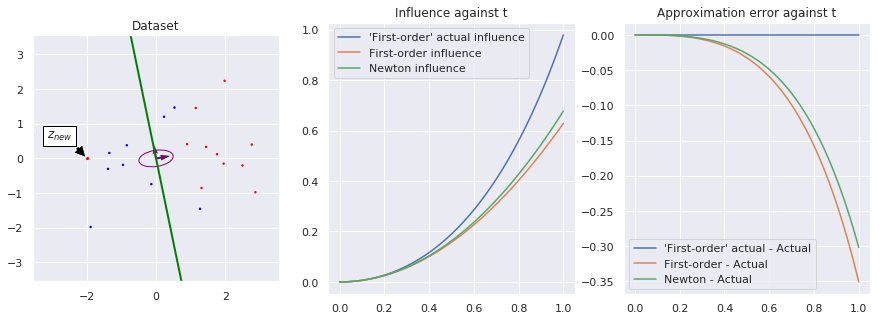

In [9]:
compare_approximations_t(X, y, (np.array([-2, 0]), 1))

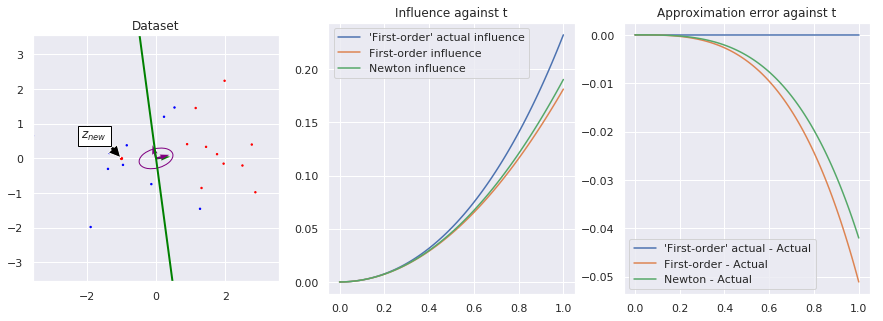

In [10]:
compare_approximations_t(X, y, (np.array([-1, 0]), 1))

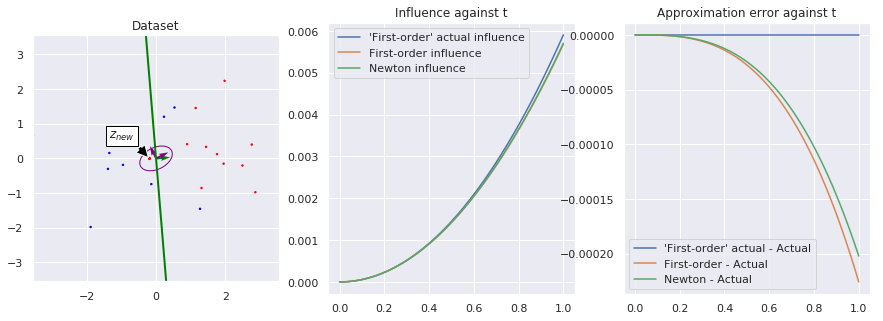

In [11]:
compare_approximations_t(X, y, (np.array([-0.2, 0]), 1))

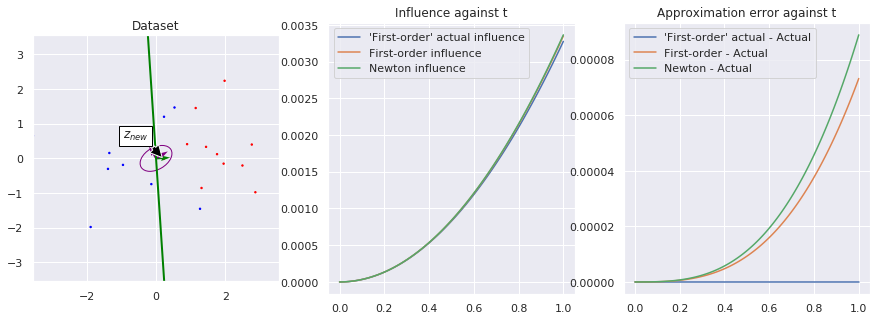

In [12]:
compare_approximations_t(X, y, (np.array([0.2, 0]), 1))

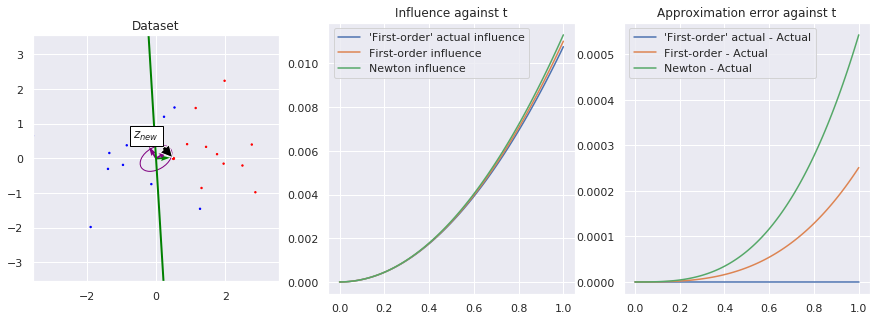

In [13]:
compare_approximations_t(X, y, (np.array([0.5, 0]), 1))

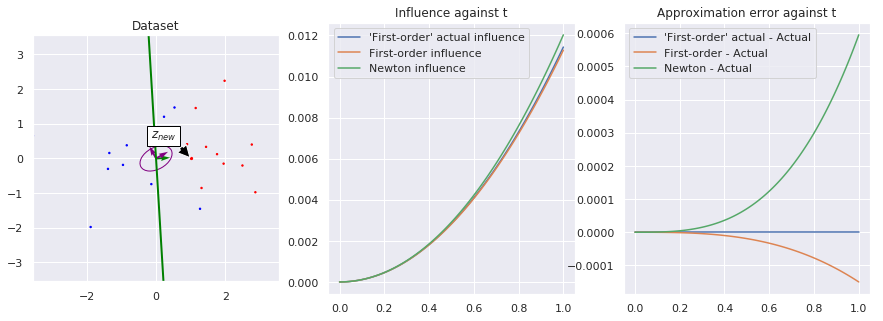

In [14]:
compare_approximations_t(X, y, (np.array([1, 0]), 1))

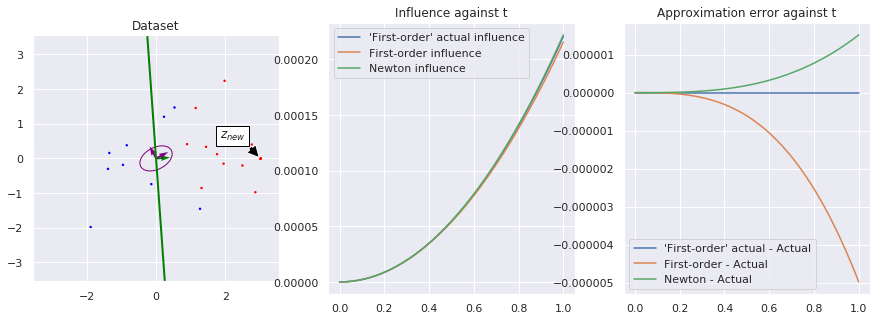

In [15]:
compare_approximations_t(X, y, (np.array([3, 0]), 1))

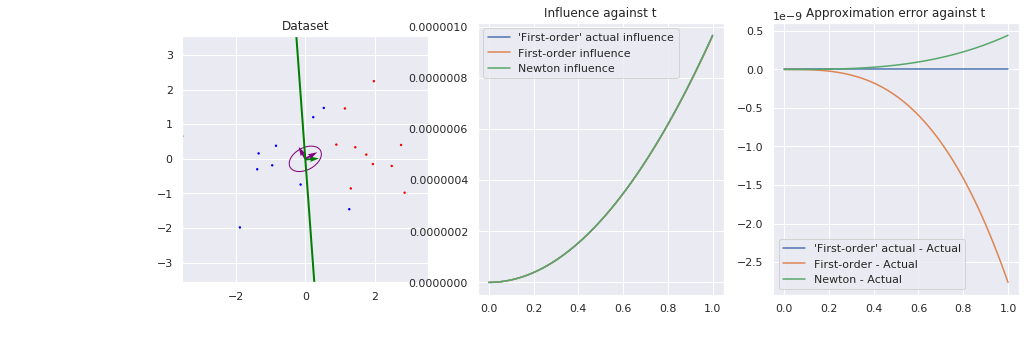

In [16]:
compare_approximations_t(X, y, (np.array([5, 0]), 1))